# Проект по автоматизации сбора, обработки и загрузки данных с логгеров


**Выполнил: Жиркова Туяра, июнь 2023**

# Описание проекта


**Задача — автоматизация сбора, обработки и загрузки данных с логгеров Института мерзлотоведения им. академика П. И. Мельникова СО РАН**

- **Загрузка данных из базы данных типа MySQL** 
- **Просмотр, анализ и предобработка данных**
- **Выгрузка данных в табличном виде в xsl файл**
- **Запуск ETL по расписанию**

**Техническая задача**

Данные приходят с двух логгеров Expreremental_2 и Expreremental_3

На логгере Expreremental_3 16 датчиков:

первый датчик на поверхности, остальные поочередно на глубине

- '0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40'
- '0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8'
- '0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee'
- '0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64'
- '0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30'
- '0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2'
- '0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c'
- '0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73'
- '0x28,0xff,0xc6,0x9d,0x17,0x20,0x8a,0x89'
- '0x28,0xff,0x30,0x75,0x17,0x20,0x8a,0xe6'
- '0x28,0xff,0x9d,0xb3,0x17,0x20,0x8a,0x09'
- '0x28,0xff,0x11,0x7b,0x17,0x20,0x8a,0xc6'
- '0x28,0xff,0x3a,0xa4,0x17,0x20,0x8a,0xd5'
- '0x28,0xff,0xa3,0xbb,0x17,0x20,0x8a,0x33'
- '0x28,0xff,0x59,0x75,0x17,0x20,0x8a,0x04'
- '0x28,0xff,0xa8,0x97,0x17,0x20,0x8a,0x21'


Данные приходят с логгеров на базу данных типа MySQL. 
 - База данных logger
 - логгер Expreremental_3
 - Таблица json
  - Колонка id - уникальный номер 
  - Колонка time - дата и время
  - Колонка string - json строка типа object с данными температуры, названия датчика, имени датчика, заряда батареи на датчике

**Чтобы оценить корректность и целостность данных:**

- Просмотреть уникальные значения температуры на каждом датчике
- Построить график количества данных 
- Проверить заряд батареи логгера



# Подготовка данных

## Загрузка данных

In [1]:
# установка нужной библиотеки 
!pip3 install psycopg2

In [2]:
# импортируем библиотеки
import pandas as pd
from datetime import datetime
import datetime
import requests
import json
from pprint import pprint 
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#считывание и сохранение данных с json файла в портфолио
with open('json.json', 'r') as f:
    data2 = json.load(f)

In [4]:
len(data2)

3

In [5]:
# вырез нужных данных
data2=data2[2]

In [6]:
len(data2)

4

In [7]:
# вырез нужных данных
data2=data2['data']

In [8]:
len(data2)

39672

In [9]:
# вырез последней части данных, для портфолио
data2=data2[5000:]

In [10]:
len(data2)

34672

In [11]:
# создание таблицы из данных
df = pd.DataFrame(data2)

df.info()

## Просмотр данных

In [12]:
df

,id,time,string
0,14632,2023-07-02 19:40:44,"{""dr"": 5, ""adr"": true, ""data"": ""Hyj/MHUXIIrmAA..."
1,14633,2023-07-02 19:40:52,"{""dr"": 5, ""adr"": true, ""data"": ""Lyg8fsg4GQGfAI..."
2,14634,2023-07-02 19:40:54,"{""tags"": {}, ""devEUI"": ""qGEKMjdCdAE="", ""margin..."
3,14635,2023-07-02 19:40:54,"{""dr"": 5, ""adr"": true, ""data"": ""Hyj/qJcXIIohAA..."
4,14636,2023-07-02 19:40:58,"{""dr"": 5, ""adr"": true, ""data"": ""Lyi8QLU5GQHNAI..."
...,...,...,...
34667,49299,2023-07-29 20:29:59,"{""dr"": 5, ""adr"": true, ""data"": ""fCj/nbMXIIoJAA..."
34668,49300,2023-07-29 20:30:09,"{""dr"": 5, ""adr"": true, ""data"": ""fCj/o7sXIIozAA..."
34669,49301,2023-07-29 20:30:19,"{""dr"": 5, ""adr"": true, ""data"": ""fCj/65gXIIocAA..."
34670,49302,2023-07-29 20:30:29,"{""dr"": 5, ""adr"": true, ""data"": ""fCj/G6AXIIruAA..."


## Предобработка данных

In [13]:
# перевод типа столбца 'id' из строчного в числовой
df['id']=pd.to_numeric(df['id'], errors='coerce')

In [14]:
# перевод типа столбца 'time' из строчного в datetime
df['time']=pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34672 entries, 0 to 34671
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      34672 non-null  int64         
 1   time    34672 non-null  datetime64[ns]
 2   string  34672 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 812.8+ KB


In [16]:
# создание таблицы для логгера "deviceName\": \"Expreremental_3\"
exp3 = pd.DataFrame(columns=['id', 'time'])

In [17]:
# скопировать столбцы 'id' и 'time' из таблицы df в таблицу exp3
for i in range(len(df)):
    exp3.loc[i,'id']=df.loc[i,'id']
    exp3.loc[i,'time']=df.loc[i,'time']

In [18]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34672 entries, 0 to 34671
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      34672 non-null  object
 1   time    34672 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [19]:
# перевод типа столбца 'id' из строчного в числовой
exp3['id']=pd.to_numeric(exp3['id'], errors='coerce')

In [20]:
# перевод типа столбца 'time' из строчного в datetime
exp3['time']=pd.to_datetime(exp3['time'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# список установленных датчиков,datchik3 на поверхности, остальное поочередно на глубине
datchik3='0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40'
datchik2='0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8'
datchik14='0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee'
datchik15='0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64'
datchik10='0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30'
datchik7='0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2'
datchik13='0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c'
datchik6='0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73'
datchik5='0x28,0xff,0xc6,0x9d,0x17,0x20,0x8a,0x89'
datchik0='0x28,0xff,0x30,0x75,0x17,0x20,0x8a,0xe6'
datchik11='0x28,0xff,0x9d,0xb3,0x17,0x20,0x8a,0x09'
datchik8='0x28,0xff,0x11,0x7b,0x17,0x20,0x8a,0xc6'
datchik4='0x28,0xff,0x3a,0xa4,0x17,0x20,0x8a,0xd5'
datchik12='0x28,0xff,0xa3,0xbb,0x17,0x20,0x8a,0x33'
datchik9='0x28,0xff,0x59,0x75,0x17,0x20,0x8a,0x04'
datchik1='0x28,0xff,0xa8,0x97,0x17,0x20,0x8a,0x21'

In [22]:
def sensor_temperature(datchik):
    keyword='Temperature'
    for i in range(len(df)):
        if datchik in df.loc[i,'string']:
            match = re.search(keyword, df.loc[i,'string'])
            if match:
                sub_string = df.loc[i,'string'][match.end()+3:]
                end_index = sub_string.find("}")
                exp3.loc[i,datchik]=sub_string[:end_index]
    return exp3.loc[i,datchik]

In [23]:
#вызов функции для всех датчиков
sensor_temperature(datchik3)
sensor_temperature(datchik2)
sensor_temperature(datchik14)
sensor_temperature(datchik15)
sensor_temperature(datchik10)
sensor_temperature(datchik7)
sensor_temperature(datchik13)
sensor_temperature(datchik6)
sensor_temperature(datchik5)
sensor_temperature(datchik0)
sensor_temperature(datchik11)
sensor_temperature(datchik8)
sensor_temperature(datchik4)
sensor_temperature(datchik12)
sensor_temperature(datchik9)
sensor_temperature(datchik1)

nan

In [24]:
exp3

,id,time,"0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40","0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8","0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee","0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64","0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30","0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2","0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c","0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73","0x28,0xff,0xc6,0x9d,0x17,0x20,0x8a,0x89","0x28,0xff,0x30,0x75,0x17,0x20,0x8a,0xe6","0x28,0xff,0x9d,0xb3,0x17,0x20,0x8a,0x09","0x28,0xff,0x11,0x7b,0x17,0x20,0x8a,0xc6","0x28,0xff,0x3a,0xa4,0x17,0x20,0x8a,0xd5","0x28,0xff,0xa3,0xbb,0x17,0x20,0x8a,0x33","0x28,0xff,0x59,0x75,0x17,0x20,0x8a,0x04","0x28,0xff,0xa8,0x97,0x17,0x20,0x8a,0x21"
0,14632,2023-07-02 19:40:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.6875,NaN,NaN,NaN,NaN,NaN,NaN
1,14633,2023-07-02 19:40:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14634,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14635,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125
4,14636,2023-07-02 19:40:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34667,49299,2023-07-29 20:29:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,NaN,NaN,NaN,NaN,NaN
34668,49300,2023-07-29 20:30:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.4375,NaN,NaN
34669,49301,2023-07-29 20:30:19,NaN,NaN,NaN,NaN,NaN,NaN,-1.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34670,49302,2023-07-29 20:30:29,NaN,NaN,6.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34672 entries, 0 to 34671
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       34672 non-null  int64         
 1   time                                     34672 non-null  datetime64[ns]
 2   0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40  545 non-null    object        
 3   0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8  545 non-null    object        
 4   0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee  537 non-null    object        
 5   0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64  536 non-null    object        
 6   0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30  540 non-null    object        
 7   0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2  542 non-null    object        
 8   0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c  537 non-null    object        
 9   0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73

In [26]:
# запись в таблицу exp3 имени девайса
device_name='Expreremental_3'
for i in range(len(df)):
    if device_name in df.loc[i,'string']:
        exp3.loc[i,'device_name']='Expreremental_3'

In [27]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34672 entries, 0 to 34671
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       34672 non-null  int64         
 1   time                                     34672 non-null  datetime64[ns]
 2   0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40  545 non-null    object        
 3   0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8  545 non-null    object        
 4   0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee  537 non-null    object        
 5   0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64  536 non-null    object        
 6   0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30  540 non-null    object        
 7   0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2  542 non-null    object        
 8   0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c  537 non-null    object        
 9   0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73

In [28]:
exp3 = exp3.dropna(subset=['device_name']) 

In [29]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9267 entries, 0 to 34671
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       9267 non-null   int64         
 1   time                                     9267 non-null   datetime64[ns]
 2   0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40  545 non-null    object        
 3   0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8  545 non-null    object        
 4   0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee  537 non-null    object        
 5   0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64  536 non-null    object        
 6   0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30  540 non-null    object        
 7   0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2  542 non-null    object        
 8   0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c  537 non-null    object        
 9   0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73 

In [30]:
exp3.columns = ['id', 'time','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','Название логгера']

In [31]:
exp3.head(20)

,id,time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Название логгера
0,14632,2023-07-02 19:40:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.6875,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
2,14634,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
3,14635,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,Expreremental_3
5,14637,2023-07-02 19:41:04,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
7,14639,2023-07-02 19:41:15,28.4375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
9,14641,2023-07-02 19:41:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,NaN,NaN,NaN,Expreremental_3
11,14643,2023-07-02 19:41:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
12,14644,2023-07-02 19:41:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
14,14646,2023-07-02 19:41:55,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
15,14647,2023-07-02 19:42:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.5625,NaN,NaN,NaN,NaN,Expreremental_3


In [32]:
#удаление строк без значений темпетаруты со е датчиков
exp3=exp3.dropna (thresh= 4)

In [33]:
# новое индексирование строк бз пропусков
exp3 = exp3.drop_duplicates().reset_index(drop=True)

In [34]:
exp3.loc

In [35]:
# начало передачи данных
exp3['time'].min()

Timestamp('2023-07-02 19:40:44')

In [36]:
# конец передачи данных
exp3['time'].max()

Timestamp('2023-07-29 20:30:40')

In [37]:
# продолжительность передачи данных
exp3['time'].max()-exp3['time'].min()

Timedelta('27 days 00:49:56')

(array([19543., 19547., 19551., 19555., 19559., 19563., 19567.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

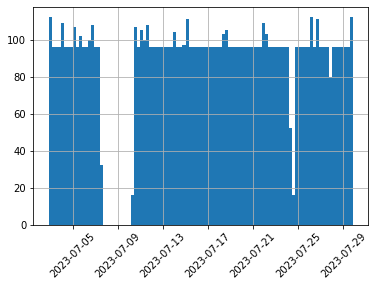

In [38]:
exp3['time'].hist(bins=100);
plt.xticks(rotation=45)

в данных пропуск возьму часть данных


(array([19549., 19551., 19553., 19555., 19557., 19559., 19561., 19563.,
        19565., 19567.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

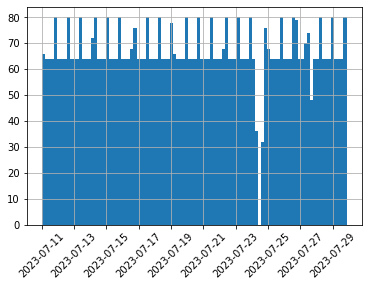

In [39]:
exp3['time'].loc[2000:].hist(bins=100);
plt.xticks(rotation=45)

In [40]:
exp3=exp3.loc[2000:]

In [41]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6657 entries, 2000 to 8656
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                6657 non-null   int64         
 1   time              6657 non-null   datetime64[ns]
 2   0                 418 non-null    object        
 3   1                 418 non-null    object        
 4   2                 416 non-null    object        
 5   3                 415 non-null    object        
 6   4                 415 non-null    object        
 7   5                 416 non-null    object        
 8   6                 415 non-null    object        
 9   7                 416 non-null    object        
 10  8                 416 non-null    object        
 11  9                 418 non-null    object        
 12  10                415 non-null    object        
 13  11                415 non-null    object        
 14  12                416

In [42]:
exp3.loc[2014,'time']

Timestamp('2023-07-11 01:43:21')

In [43]:
exp3

,id,time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Название логгера
2000,23581,2023-07-11 00:40:39,NaN,NaN,4.6875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
2001,23582,2023-07-11 00:40:49,NaN,NaN,NaN,0.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
2002,23607,2023-07-11 01:41:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.5625,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
2003,23610,2023-07-11 01:41:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,Expreremental_3
2004,23611,2023-07-11 01:41:40,NaN,10.5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,49299,2023-07-29 20:29:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,NaN,NaN,NaN,NaN,NaN,Expreremental_3
8653,49300,2023-07-29 20:30:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.4375,NaN,NaN,Expreremental_3
8654,49301,2023-07-29 20:30:19,NaN,NaN,NaN,NaN,NaN,NaN,-1.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
8655,49302,2023-07-29 20:30:29,NaN,NaN,6.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3


In [44]:
now = datetime.datetime.now()
rounded_minute = int((now.minute // 5) * 5)
rounded_time = now.replace(minute=rounded_minute, second=0, microsecond=0)
print(rounded_time.strftime('%Y-%m-%d %H:%M:%S'))

2023-09-06 14:05:00


In [45]:
now.info()

AttributeError: 'datetime.datetime' object has no attribute 'info'

In [ ]:

for i in range(2000,8656):
    exp3['timee'][i]=(exp3['time'][i]).to_pydatetime()
    #exp3.loc[i,'rounded_minute']=int((exp3.loc[i,'time'].minute//10)*10)

    

In [ ]:
exp3.info()

In [ ]:
for i in range(2000,8656):    
    exp3.loc[i,'rounded_time']=exp3.loc[i,'time'].replace(minute=exp3.loc[i,'rounded_minute'], second=0, microsecond=0)

In [ ]:
exp3

In [ ]:
fsdcsdv

In [ ]:
# выгрузка в xslx файл
exp3.to_excel('./exp3_logger.xlsx')

In [ ]:
# цикл для записи температуры датчика
datchik3='0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40'
#string = df.loc[1,'string']
keyword='Temperature'

for i in range(len(df)):
    if datchik3 in df.loc[i,'string']:
        match = re.search(keyword, df.loc[i,'string'])
        #print('match=',match)
        if match:
            sub_string = df.loc[i,'string'][match.end()+3:]
            end_index = sub_string.find("}")
            df.loc[i,'datchik3']=sub_string[:end_index]